# Mapa das eleições de Dep. Estadual de 2018 por Zona Eleitoral no estado de SP

In [ ]:
'''
Fontes:
IBGE - shapefiles
https://mapas.ibge.gov.br/bases-e-referenciais/bases-cartograficas/malhas-digitais.html
ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2015/Brasil/BR/br_municipios.zip

TSE - resultado eleição
http://www.tse.jus.br/eleicoes/estatisticas/repositorio-de-dados-eleitorais-1/repositorio-de-dados-eleitorais/
http://agencia.tse.jus.br/estatistica/sead/odsele/votacao_candidato_munzona/votacao_candidato_munzona_2018.zip
http://www.tse.jus.br/eleitor/cartorios-e-zonas-eleitorais/pesquisa-a-zonas-eleitorais

mapaslivres - correspondencia entre TSE e IBGE
https://github.com/mapaslivres/zonas-eleitorais

Estadão Dados - zonas eleitorais
https://drive.google.com/drive/u/1/folders/1qwTlkNnt5SEnzirhrXbSXGST6vNvUAVM

Dados Abertos SP - shapefile
http://dados.prefeitura.sp.gov.br/pt_PT/dataset/distritos/resource/9e75c2f7-5729-4398-8a83-b4640f072b5d
'''

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
# Read input file in order to collect voting database in chunks due file size
df_chunk = pd.read_csv('./votos/votacao_candidato_munzona_2018_SP.csv', sep=';', encoding='latin1', chunksize=10000)

In [3]:
cols = ['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NR_ZONA', 'DS_CARGO',
        'NR_CANDIDATO', 'NM_URNA_CANDIDATO', 'NR_PARTIDO', 'SG_PARTIDO', 
        'QT_VOTOS_NOMINAIS']

DS_CARGO = 'Deputado Estadual'
NR_CANDIDATO = 17317

In [4]:
chunk_list = []

# Each chunk is in df format
for chunk in df_chunk:  
    # perform data filtering 
    chunk_filter = chunk[chunk['DS_CARGO'] == DS_CARGO]
    #chunk_filter = chunk_filter[chunk_filter['NR_CANDIDATO'] == NR_CANDIDATO]
    chunk_filter = chunk_filter[cols]
    
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk_filter)
    
# concat the list into dataframe 
df_concat = pd.concat(chunk_list)

In [5]:
df_concat.head()

,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,DS_CARGO,NR_CANDIDATO,NM_URNA_CANDIDATO,NR_PARTIDO,SG_PARTIDO,QT_VOTOS_NOMINAIS
2,68039,PALMARES PAULISTA,111,Deputado Estadual,51322,ALICE LIMBERG,51,PATRI,0
4,68730,PIRACAIA,92,Deputado Estadual,70717,FERNANDO APPEZZATO,70,AVANTE,0
5,61310,AMERICANA,384,Deputado Estadual,15056,FERNANDO ESPANHOL,15,MDB,0
6,61158,ALFREDO MARCONDES,182,Deputado Estadual,77154,DRA. FLOR,77,SOLIDARIEDADE,0
7,69310,PRESIDENTE VENCESLAU,102,Deputado Estadual,14340,CAROL CERQUEIRA,14,PTB,2


In [6]:
# Filtering candidate number
df_candidato = df_concat[df_concat['NR_CANDIDATO'] == NR_CANDIDATO]

In [7]:
df_zona = df_candidato.groupby(['NR_ZONA', 'NM_URNA_CANDIDATO'])['QT_VOTOS_NOMINAIS'].sum().reset_index()

In [8]:
df_zona.head()

,NR_ZONA,NM_URNA_CANDIDATO,QT_VOTOS_NOMINAIS
0,1,JANAINA PASCHOAL,12117
1,2,JANAINA PASCHOAL,18932
2,3,JANAINA PASCHOAL,4970
3,4,JANAINA PASCHOAL,20264
4,5,JANAINA PASCHOAL,16191


In [9]:
# Total candidate votes
df_zona['QT_VOTOS_NOMINAIS'].sum()

2060786

In [10]:
# Importing shapefile
df_mapa = gpd.read_file('./geo/SP_ZONAS_janeiro_2018/ZONAS_FINAL.shp')

In [11]:
df_mapa_novo = df_mapa.join(df_zona)

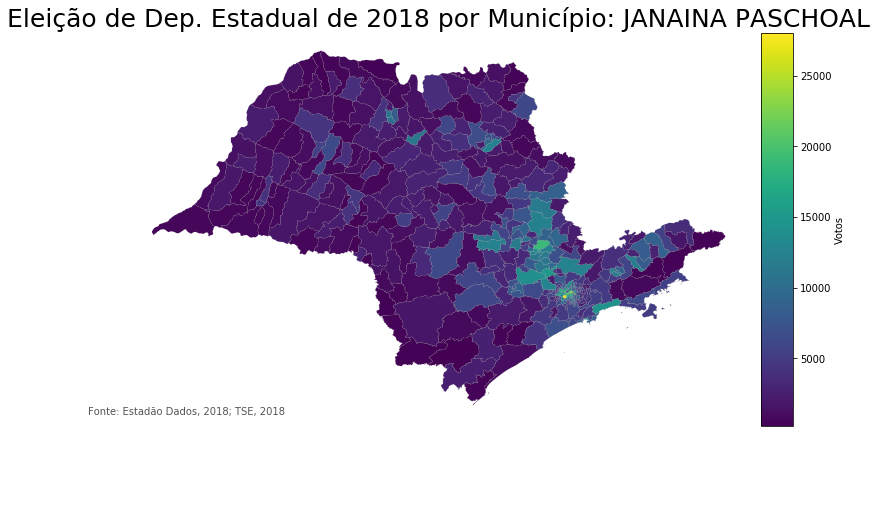

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(12,12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = df_mapa_novo.plot(column='QT_VOTOS_NOMINAIS', legend=True,
                       legend_kwds={'label': "Votos", 'orientation': "vertical"}, 
                       linewidth=0.1, ax=ax, cax=cax, edgecolor='grey')
ax.set_axis_off()
ax.set_title('Eleição de Dep. Estadual de 2018 por Município: '+ df_zona['NM_URNA_CANDIDATO'][0], fontdict={'fontsize':'25', 'fontweight':'3'})
ax.annotate('Fonte: Estadão Dados, 2018; TSE, 2018', xy=(0.1,0.2),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=10, color='#555555')
plt.show()
fig.savefig('sp-estado.png')